# Python Script for ASPA WUDR Project

In [1]:
#Import relevant packages
import os
import re
import pandas as pd
import requests
import boto3
from io import BytesIO, StringIO
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
##DELETE IMMIDIATELY ONCE SET ##
os.environ['GITHUB_TOKEN'] = ''

## Access Data

The water usage data files are stored in a private github repo. They are all formated as excel files and can be accessed from the repo with a GitHub_token from anyone granted access. 

In [4]:
def get_xlsx_files_from_repo(repo_url, token):
    headers = {
        'Authorization': f'token {token}'
    }
    response = requests.get(repo_url, headers=headers)
    if response.status_code == 200:
        items = response.json()
        xlsx_files = []
        for item in items:
            if item['type'] == 'file' and item['name'].endswith('.xlsx'):
                xlsx_files.append(item['download_url'])
            elif item['type'] == 'dir':
                xlsx_files += get_xlsx_files_from_repo(item['url'], token)
        return xlsx_files
    else:
        raise ValueError(f"Failed to fetch repository contents: {response.status_code}")
        
repo_url = "https://api.github.com/repos/cshuler/ASPA_WUDR_Input_Files/contents/Data/2022"
token = os.environ.get('GITHUB_TOKEN')
if not token:
    raise ValueError("GitHub token not found in environment variables")

xlsx_files = get_xlsx_files_from_repo(repo_url, token)
print(xlsx_files[:5])  


['https://raw.githubusercontent.com/cshuler/ASPA_WUDR_Input_Files/main/Data/2022/2022/Water%20Usage%20Sales%20prompt%20by%20billing_202201a.xlsx?token=AHFNTV3BHKYD544CMJOVST3G26KUU', 'https://raw.githubusercontent.com/cshuler/ASPA_WUDR_Input_Files/main/Data/2022/2022/Water%20Usage%20Sales%20prompt%20by%20billing_202202a.xlsx?token=AHFNTVZV3NEZQOOLULFKX6LG26KUU', 'https://raw.githubusercontent.com/cshuler/ASPA_WUDR_Input_Files/main/Data/2022/2022/Water%20Usage%20Sales%20prompt%20by%20billing_202203a.xlsx?token=AHFNTVYXM3JGI5M6YYPNJ4LG26KUU', 'https://raw.githubusercontent.com/cshuler/ASPA_WUDR_Input_Files/main/Data/2022/2022/Water%20Usage%20Sales%20prompt%20by%20billing_202204a.xlsx?token=AHFNTV7IMUSNCUETPO45CD3G26KUU', 'https://raw.githubusercontent.com/cshuler/ASPA_WUDR_Input_Files/main/Data/2022/2022/Water%20Usage%20Sales%20prompt%20by%20billing_202205a.xlsx?token=AHFNTV7TNN7NZTQY5SARSS3G26KUU']


This confirms we have sucessfully accesed all excel files present in the repo. Now, we need convert them into dataframes, then combine all the dataframes.

In [5]:
def read_xlsx_files(xlsx_files, token):
    headers = {
        'Authorization': f'token {token}'
    }
    dataframes = []
    for file_url in xlsx_files:
        response = requests.get(file_url, headers=headers)
        if response.status_code == 200:
            df = pd.read_excel(BytesIO(response.content))
            dataframes.append(df)
        else:
            raise ValueError(f"Failed to download file: {response.status_code}")
    return dataframes

#Combine all dataframes into one big dataframe
def combine_dataframes(dataframes):
    cs_data = pd.concat(dataframes, ignore_index=True)
    return cs_data

dataframes = read_xlsx_files(xlsx_files, token)
cs_data = combine_dataframes(dataframes)
cs_data.head()

,HIACCT,HISUB,NAME,Svc,Rdg Date,Rdg,Usage,Days of Usage,Billed Amount for Water,MTH/YR OF BILLING,...,Rate,LOMETW,Meter Size,LOMPW,Unnamed: 17,30.371223603112053,Unnamed: 18,1830,Production,Rdg
0,6472.0,1.0,ASPA:WATER 911 - 341(ATUU#2),3.0,2022-01-13,623699.0,4821760.0,15.0,0.00,202201.0,...,NC3,141630302.0,"2""",19.0,NaN,NaN,NaN,NaN,NaN,NaN
1,6465.0,1.0,ASPA:WATER 900 - 341(FAGAALU),3.0,2022-01-05,79200.0,33283000.0,29.0,0.00,202201.0,...,NC3,96323412.0,"4""",21.0,NaN,NaN,NaN,NaN,NaN,NaN
2,4276.0,1.0,AFIOMAI APARTMENT #3,3.0,2022-01-19,11.0,0.0,34.0,15.21,202201.0,...,R,90277756.0,"5/8""",23.0,NaN,NaN,NaN,NaN,NaN,NaN
3,34308.0,1.0,"SALA, FUAROSA.",3.0,2022-01-21,480.0,315.0,32.0,16.48,202201.0,...,R,90277755.0,"5/8""",0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,22280.0,1.0,AFIOMAI APARTMENT (APT#5),3.0,2022-01-19,173563.0,7074.0,34.0,43.66,202201.0,...,R,90277754.0,"5/8""",23.0,NaN,NaN,NaN,NaN,NaN,NaN


## Data cleaning begins

We now have our dataframe "cs_data" that contains all the excel files combined. This will be our main dataframe that we will work to clean before we transform/aggregate it for the final structure. We need to extract relevant information from this large dataframe

In [51]:
def clean_data(cs_data):
    #stripping column names
    cs_data.columns = [str(col).strip() for col in cs_data.columns]
    cs_data = cs_data[cs_data['LOSADD'].notnull()]
    cs_data['Usage'] = cs_data['Usage'].astype(str).str.replace(" ", "")
    cs_data['Usage'] = cs_data['Usage'].str.replace("-", "0")
    cs_data['Usage'] = cs_data['Usage'].str.replace(",", "")
    cs_data['Usage'] = pd.to_numeric(cs_data['Usage'], errors='coerce')
    pattern = re.compile(r'ASPA:WATER\s*\d+')
    cs_data['SiteTypeCV'] = cs_data['NAME'].apply(lambda x: 'Production Well' if pattern.match(x) else 'Unspecified')
    return cs_data #Creating sitetypceCV
cs_data = clean_data(cs_data)

def map_rsp_to_beneficial_use_category(cs_data): #Benenficial Use Category Definition
    rsp_mapping = {
        'RES': 'Domestic',
        'IND': 'Industrial',
        'LGS': 'Industrial',
        'SGS': 'Commercial',
        'ASG': 'Commercial'
    }
    
    #Compile the pattern that indicates a well
    pattern = re.compile(r'ASPA:WATER\s*\d+') #ASPA followed by a number. This method is further refined later when creating our well dataframe
    
    #Apply the mapping
    cs_data['BeneficialUseCategory'] = cs_data['RSP'].map(rsp_mapping)
    
    #Update the BeneficialUseCategory to 'Well' where the pattern matches
    cs_data['BeneficialUseCategory'] = cs_data.apply(
        lambda row: 'Production Well' if pattern.match(row['NAME']) else row['BeneficialUseCategory'],
        axis=1
    )
    
    return cs_data
cs_data = map_rsp_to_beneficial_use_category(cs_data)
cs_data.head()

,HIACCT,HISUB,NAME,Svc,Rdg Date,Rdg,Usage,Days of Usage,Billed Amount for Water,MTH/YR OF BILLING,...,Unnamed: 18,1830,Production,Rdg,SiteTypeCV,BeneficialUseCategory,TimeframeStart,Month,Well_Number,TimeframeEnd
0,6472.0,1.0,ASPA:WATER 911 - 341(ATUU#2),3.0,2022-01-13,623699.0,4821760.0,15.0,0.00,2022-01-01,...,NaN,NaN,NaN,NaN,Production Well,Production Well,2022-01-01,2021-12,911,2022-01-31
1,6465.0,1.0,ASPA:WATER 900 - 341(FAGAALU),3.0,2022-01-05,79200.0,33283000.0,29.0,0.00,2022-01-01,...,NaN,NaN,NaN,NaN,Production Well,Production Well,2022-01-01,2021-12,900,2022-01-31
2,4276.0,1.0,AFIOMAI APARTMENT #3,3.0,2022-01-19,11.0,0.0,34.0,15.21,2022-01-01,...,NaN,NaN,NaN,NaN,Unspecified,Domestic,2022-01-01,2021-12,None,2022-01-31
3,34308.0,1.0,"SALA, FUAROSA.",3.0,2022-01-21,480.0,315.0,32.0,16.48,2022-01-01,...,NaN,NaN,NaN,NaN,Unspecified,Domestic,2022-01-01,2021-12,None,2022-01-31
4,22280.0,1.0,AFIOMAI APARTMENT (APT#5),3.0,2022-01-19,173563.0,7074.0,34.0,43.66,2022-01-01,...,NaN,NaN,NaN,NaN,Unspecified,Domestic,2022-01-01,2021-12,None,2022-01-31


### Data Cleaning: QA/QC Checks 

QA/QC checks for usage data. Anything greater than 3 standard deviations from the mean of a beneficial use category per month is filtered out. The well data is filtered later in the well cleaning function

In [52]:
def qa_qc_checks(cs_data):
    cs_data['TimeframeStart'] = pd.to_datetime(cs_data['Rdg Date']) - pd.to_timedelta(cs_data['Days of Usage'], unit='D')
    cs_data['Month'] = cs_data['TimeframeStart'].dt.to_period('M').astype(str)
    
    #Calculate the mean and standard deviation for each LOSADD and BeneficialUseCategory
    cs_data['Mean'] = cs_data.groupby(['LOSADD', 'BeneficialUseCategory'])['Usage'].transform('mean')
    cs_data['StdDev'] = cs_data.groupby(['LOSADD', 'BeneficialUseCategory'])['Usage'].transform('std')
    cs_data['UpperLimit'] = cs_data['Mean'] + 3 * cs_data['StdDev']
    cs_data['LowerLimit'] = cs_data['Mean'] - 3 * cs_data['StdDev']
    
    #Debugging
    print("QA Data with Limits Preview:")
    print(cs_data.head())
    cs_data.to_csv('cs_data_with_limits.csv', index=False)
    
    #Filtering data based on the limits
    initial_count = len(cs_data)
    filtered_data = cs_data[(cs_data['Usage'] >= cs_data['LowerLimit']) & (cs_data['Usage'] <= cs_data['UpperLimit'])]
    filtered_count = len(filtered_data)
    
    #Print the number of data points filtered out
    print(f"Filtered out {initial_count - filtered_count} data points out of {initial_count}")
    
    #Dropping columns used for QA/QC only if they exist
    columns_to_drop = ['Mean', 'StdDev', 'UpperLimit', 'LowerLimit']
    existing_columns = [col for col in columns_to_drop if col in filtered_data.columns]
    filtered_data = filtered_data.drop(columns=existing_columns)
    
    #Debugging
    print("Filtered Data Preview:")
    print(filtered_data.head())
    filtered_data.to_csv('filtered_data.csv', index=False)
    
    return filtered_data
cs_data = qa_qc_checks(cs_data)

QA Data with Limits Preview:
    HIACCT  HISUB                           NAME  Svc   Rdg Date       Rdg  \
0   6472.0    1.0   ASPA:WATER 911 - 341(ATUU#2)  3.0 2022-01-13  623699.0   
1   6465.0    1.0  ASPA:WATER 900 - 341(FAGAALU)  3.0 2022-01-05   79200.0   
2   4276.0    1.0           AFIOMAI APARTMENT #3  3.0 2022-01-19      11.0   
3  34308.0    1.0                 SALA, FUAROSA.  3.0 2022-01-21     480.0   
4  22280.0    1.0      AFIOMAI APARTMENT (APT#5)  3.0 2022-01-19  173563.0   

        Usage  Days of Usage  Billed Amount for Water MTH/YR OF BILLING  ...  \
0   4821760.0           15.0                     0.00        2022-01-01  ...   
1  33283000.0           29.0                     0.00        2022-01-01  ...   
2         0.0           34.0                    15.21        2022-01-01  ...   
3       315.0           32.0                    16.48        2022-01-01  ...   
4      7074.0           34.0                    43.66        2022-01-01  ...   

        SiteTypeCV Be

Defining the village key

In [53]:
village_key = {
    'AASU': "Aasu",
    'AASU FOU': 'Aasu',
    'AFAO': 'Afao',
    'AFONO': 'Afono',
    'AGUGULU': 'Agugulu',
    'ALAO': 'Alao',
    'ALEGA': 'Alega',
    'ALOFAU': 'Alofau',
    'AMALUIA': 'Amaluia',
    'AMANAVE': 'Amanave',
    'AMAUA': 'Amaua',
    'AMOULI': 'Amouli',
    'AOA': 'Aoa',
    'AOLOAU': 'Aoloau',
    'ASILI': 'Asili',
    'ATAULOMA': 'Afao',
    'ATUU': 'Atuu',
    'AUA': 'Aua',
    'AUASI': 'Auasi',
    'AUNUU': 'Aunuu',
    'AUTO': 'Auto',
    'AVAIO': 'Avaio',
    'FAGAALU': 'Fagaalu',
    'FAGAITUA': 'Fagaitua',
    'FAGALII': 'Fagalii',
    'FAGAMALO': 'Fagamalo',
    'FAGANEANEA': 'Faganeanea',
    'FAGASA': 'Fagasa',
    'FAGATOGO': 'Fagatogo',
    'FAILOLO': 'Failolo',
    'FALEASAO': 'Tau',
    'FALENIU': 'Faleniu',
    'FATUMAFUTI': 'Fatumafuti',
    'FITIUTA': 'Tau',
    'FOGAGOGO': 'Iliili', 
    'FUTIGA': 'Futiga',
    'Fagaalu': 'Fagaalu',
    'GATAIVAI': 'Utulei',
    'ILIILI': 'Iliili',
    'LAULII': 'Laulii',
    'LELOALOA': 'Leloaloa',
    'LEONE': 'Leone',
    'MALAEIMI': 'Malaeimi',
    'MALAELOA': 'Malaeloa',
    'MALALOA': 'Fagatogo',
    'MALOATA': 'Maloata',
    'MAPUSAGA': 'Mapusagafou',
    'MAPUSAGA FOU': 'Mapusagafou',
    'MASAUSI': 'Masausi',
    'MASEFAU': 'Masefau',
    'MATUU': 'Matuu',
    'MESEPA': 'Mesepa',
    'NUA': 'Nua',
    'NUUULI': 'Nuuuli',
    'OFU': 'Ofu',
    'OLOSEGA': 'Olosega',
    'ONENOA': 'Onenoa',
    'PAGAI': 'Pagai',
    'PAGO PAGO': 'Pago Pago',
    'PAVAIAI': 'Pavaiai',
    'POLOA': 'Poloa',
    'SAILELE': 'Sailele',
    'SATALA': 'Pago Pago',
    'SEETAGA': 'Seetaga',
    'TAFETA': 'Mapusagafou',
    'TAFUNA': 'Tafuna',
    'TAPUTIMU': 'Taputimu',
    'TAU': 'Tau',
    'TULA': 'Tula',
    'UTULEI': 'Utulei',
    'UTUMEA': 'Utumea West',
    'UTUMEA-SASAE': 'Utumea East',
    'UTUSIA': 'Fagaitua',
    'VAILOA': 'Vailoatai',
    'VAITOGI': 'Vaitogi',
    'VATIA': 'Vatia',
    'Vaitogi': 'Vaitogi'
}

### Data Cleaning: Transforming and Aggreating Main Dataset

This is where the data from cs_data is transfered into another dataframe where the columns specified by Wade Schema.

In [54]:
def transform_to_site_specific_format(cs_data):
   
    
   transformed_data = pd.DataFrame(columns=['SiteNativeID','VariableSpecificUUID', 'Amount', 'BeneficialUseCategory', 'TimeframeStart', 'TimeframeEnd'])
    
   # Map the villages using SiteNativeID
   transformed_data['SiteNativeID'] = cs_data['LOSADD'].map(village_key) #use of village key
   transformed_data['VariableSpecificUUID'] = 'UTssps_V3'
   transformed_data['Amount'] = cs_data['Usage']
   transformed_data['BeneficialUseCategory'] = cs_data['BeneficialUseCategory']

   cs_data['MTH/YR OF BILLING'] = pd.to_datetime(cs_data['MTH/YR OF BILLING'], format='%Y%m')
   transformed_data['TimeframeStart'] = cs_data['MTH/YR OF BILLING'].dt.to_period('M').dt.to_timestamp()
   transformed_data['TimeframeEnd'] = cs_data['MTH/YR OF BILLING'] + pd.offsets.MonthEnd(0)
   transformed_data['Month'] = transformed_data['TimeframeStart'].dt.to_period('M')

   #Aggregate usage per month, village, and beneficial use category
   aggregated_data = transformed_data.groupby(['SiteNativeID', 'Month', 'BeneficialUseCategory'])['Amount'].sum().reset_index()

   #Convert 'Month' back to datetime and calculate TimeframeStart and TimeframeEnd for the final format
   aggregated_data['TimeframeStart'] = aggregated_data['Month'].dt.to_timestamp()
   aggregated_data['TimeframeEnd'] = aggregated_data['TimeframeStart'] + pd.offsets.MonthEnd(0)

   #Adjust the column names to match the example output
   aggregated_data = aggregated_data[['SiteNativeID', 'BeneficialUseCategory', 'TimeframeStart', 'TimeframeEnd', 'Amount']]
   aggregated_data['VariableCV'] = aggregated_data['BeneficialUseCategory'].apply(
    lambda x: 'Withdrawal' if x == 'Production Well' else 'Consumptive Use'
   )
   aggregated_data['ReportYear'] = aggregated_data['TimeframeStart'].dt.year

   #Sort the data for better readability
   aggregated_data = aggregated_data.sort_values(by=['SiteNativeID', 'TimeframeStart', 'BeneficialUseCategory'])
   
   return aggregated_data
aggregated_data = transform_to_site_specific_format(cs_data)
print(aggregated_data.head())

  SiteNativeID BeneficialUseCategory TimeframeStart TimeframeEnd     Amount  \
0         Aasu            Commercial     2022-01-01   2022-01-31     5008.0   
1         Aasu              Domestic     2022-01-01   2022-01-31   602558.0   
2         Aasu       Production Well     2022-01-01   2022-01-31  1291200.0   
3         Aasu            Commercial     2022-02-01   2022-02-28     3592.0   
4         Aasu              Domestic     2022-02-01   2022-02-28   423722.0   

        VariableCV  ReportYear  
0  Consumptive Use        2022  
1  Consumptive Use        2022  
2       Withdrawal        2022  
3  Consumptive Use        2022  
4  Consumptive Use        2022  


### Data Cleaning: Formatting Well Data 

This function performs all the data cleaning, qa/qc filtering, and final aggregation of all well data

In [55]:
def well_data(well_data_url, cs_data, village_key):
    #well data is in the same repo 
    access_token = os.getenv('GITHUB_TOKEN')
    headers = {'Authorization': f'token {access_token}'}

    #Fetch the well data from the GitHub URL
    response_well = requests.get(well_data_url, headers=headers)
    response_well.raise_for_status()  # Ensure we notice bad responses
    well_data = pd.read_csv(StringIO(response_well.text))
    
    #Define the pattern to match 'ASPA:WATER' followed by digits
    pattern = re.compile(r'ASPA:WATER\s*(\d+)')
    
#MATCH WELLS FROM CS_DATA TO WELLS IN THE DATAFRAME. 

    #Extract well numbers from 'NAME' in cs_data
    cs_data['Well_Number'] = cs_data['NAME'].apply(lambda x: pattern.findall(x)[0] if pattern.findall(x) else None)
    #Ensure Well_Number is of the same type for matching
    cs_data['Well_Number'] = cs_data['Well_Number'].astype(str)
    well_data['Well_Number'] = well_data['Well #'].astype(str)
    
    #Create well_data_frame containing the desired columns
    well_data_frame = well_data[['Village', 'Well_Number', 'Lat', 'Long']].dropna(subset=['Well_Number'])
    well_data_frame['SiteNativeID'] = well_data_frame.apply(lambda row: f"{row['Village']}_Well_{row['Well_Number']}", axis=1)
    well_data_frame['SiteTypeCV'] = 'Withdrawal'
    well_data_frame = well_data_frame.drop_duplicates()
    well_data_frame = well_data_frame.drop(columns=['Well_Number', 'Village'])

    cs_data['MTH/YR OF BILLING'] = pd.to_datetime(cs_data['MTH/YR OF BILLING'], format='%Y%m')
    #Calculate TimeframeStart as the first day of the month
    cs_data['TimeframeStart'] = cs_data['MTH/YR OF BILLING'].dt.to_period('M').dt.to_timestamp()
    #Calculate TimeframeEnd as the last day of the month
    cs_data['TimeframeEnd'] = cs_data['MTH/YR OF BILLING'] + pd.offsets.MonthEnd(0)

    #Filter cs_data to include only matched wells
    matched_well_data = cs_data[cs_data['Well_Number'].isin(well_data['Well_Number'])]

    #Select the relevant columns for matched_well_data DataFrame
    matched_well_data = matched_well_data[['Well_Number', 'TimeframeStart', 'TimeframeEnd', 'Usage', 'NAME', 'BeneficialUseCategory', 'LOSADD']]

    #Map the villages using LOSADD
    matched_well_data['Village'] = matched_well_data['LOSADD'].map(village_key)
    
    #Assign SiteNativeID to be the well name
    matched_well_data['SiteNativeID'] = matched_well_data.apply(lambda row: f"{row['Village']}_Well_{row['Well_Number']}", axis=1)
   
    
    # Create transformed_well_data similar to your workflow
    transformed_well_data = pd.DataFrame(columns=['SiteNativeID', 'VariableSpecificUUID', 'Amount', 'BeneficialUseCategory', 'TimeframeStart', 'TimeframeEnd'])
    transformed_well_data['SiteNativeID'] = matched_well_data['SiteNativeID']
    transformed_well_data['VariableSpecificUUID'] = 'UTssps_V3'
    transformed_well_data['Amount'] = matched_well_data['Usage']
    transformed_well_data['BeneficialUseCategory'] = matched_well_data['BeneficialUseCategory']
    transformed_well_data['TimeframeStart'] = matched_well_data['TimeframeStart']
    transformed_well_data['TimeframeEnd'] = matched_well_data['TimeframeEnd']

    #Aggregate usage per month and beneficial use category
    transformed_well_data['Month'] = transformed_well_data['TimeframeStart'].dt.to_period('M')
    #Filter out data points exceeding 17,520,000 gallons per month (max well is 400 gpm)
    max_threshold = 17520000
    total_count = transformed_well_data.shape[0]
    filtered_out_count = transformed_well_data[transformed_well_data['Amount'] > max_threshold].shape[0]
    transformed_well_data = transformed_well_data[transformed_well_data['Amount'] <= max_threshold]
    
    #Print the number of filtered data points
    print(f"Filtered out {filtered_out_count} data points out of {total_count} total points exceeding {max_threshold} gallons per month.")
    
    
    aggregated_well_data = transformed_well_data.groupby(['SiteNativeID', 'Month', 'BeneficialUseCategory'])['Amount'].sum().reset_index()

    #Convert 'Month' back to datetime and calculate TimeframeStart and TimeframeEnd for the final format
    aggregated_well_data['TimeframeStart'] = aggregated_well_data['Month'].dt.to_timestamp()
    aggregated_well_data['TimeframeEnd'] = aggregated_well_data['TimeframeStart'] + pd.offsets.MonthEnd(0)

    #Adjust the column names to match the example output
    aggregated_well_data = aggregated_well_data[['SiteNativeID', 'BeneficialUseCategory', 'TimeframeStart', 'TimeframeEnd', 'Amount']]
    aggregated_well_data['VariableCV'] = aggregated_well_data['BeneficialUseCategory'].apply(
        lambda x: 'Withdrawal' if x == 'Production Well' else 'Consumptive Use'
    )
    aggregated_well_data['ReportYear'] = aggregated_well_data['TimeframeStart'].dt.year

    #Sort the data for better readability
    aggregated_well_data = aggregated_well_data.sort_values(by=['SiteNativeID', 'TimeframeStart', 'BeneficialUseCategory'])

    return well_data_frame, aggregated_well_data,transformed_well_data

#Call function

 # Remove 'Well' entries from the first aggregated data
aggregated_data = aggregated_data[aggregated_data['BeneficialUseCategory'] != 'Production Well']
    
well_data_url = "https://raw.githubusercontent.com/cshuler/ASPA_WUDR_Input_Files/main/Well%20Info%20-%20Sheet1.csv"
village_url = "https://raw.githubusercontent.com/cshuler/ASPA_WUDR_Input_Files/main/Village_Centroid_points%20-%20Sheet1.csv"
    
well_data_frame, aggregated_well_data,transformed_well_data = well_data(well_data_url, cs_data, village_key) 
print(aggregated_well_data.head())

Filtered out 57 data points out of 1549 total points exceeding 17520000 gallons per month.
    SiteNativeID BeneficialUseCategory TimeframeStart TimeframeEnd     Amount  \
0  Aasu_Well_128       Production Well     2022-01-01   2022-01-31  1291200.0   
1  Aasu_Well_128       Production Well     2022-02-01   2022-02-28   703500.0   
2  Aasu_Well_128       Production Well     2022-03-01   2022-03-31   791800.0   
3  Aasu_Well_128       Production Well     2022-04-01   2022-04-30  1171000.0   
4  Aasu_Well_128       Production Well     2022-06-01   2022-06-30  1085400.0   

   VariableCV  ReportYear  
0  Withdrawal        2022  
1  Withdrawal        2022  
2  Withdrawal        2022  
3  Withdrawal        2022  
4  Withdrawal        2022  


In [39]:
# Load up sites
url = "https://try-test.sfo3.digitaloceanspaces.com/Sites.csv"
Sites_df = pd.read_csv(url)
Sites_df

,Lat,Long,SiteNativeID,SiteTypeCV
0,-14.283838,-170.553583,Aunuu,Village (aggregation of individual water mete...
1,-14.319156,-170.743009,Mesepa,Village (aggregation of individual water mete...
2,-14.330549,-170.768187,Malaeloa Aitulagi,Village (aggregation of individual water mete...
3,-14.333156,-170.752700,Pavaiai,Village (aggregation of individual water mete...
4,-14.327548,-170.743654,Faleniu,Village (aggregation of individual water mete...
...,...,...,...,...
129,-14.307137,-170.735710,Malaeimi_Well_4,Withdrawal
130,-14.323830,-170.748014,Mesepa_Well_6,Withdrawal
131,-14.334561,-170.774604,Malaeloa_Well_15,Withdrawal
132,-14.304541,-170.709720,Nuuuli_Well_24B,Withdrawal


In [40]:
# Pull out the average well usage by well site

# Load up sites
url = "https://try-test.sfo3.digitaloceanspaces.com/Sites.csv"
Sites_df = pd.read_csv(url)

average_amount_per_site = aggregated_well_data.groupby('SiteNativeID')['Amount'].mean().reset_index()

# Displaying the result
average_amount_per_site['Amount_GPM'] = average_amount_per_site['Amount'] /43834

# Merge on the lat lon
average_amount_per_site = pd.merge(average_amount_per_site, Sites_df[['Lat', 'Long', 'SiteNativeID']], on='SiteNativeID', how='left')
average_amount_per_site.to_csv("MissingLatLons_check2.csv")

### Unit Conversions 
- 43834 gallons per month = gallons per min  (GPM) 
- 0.00144 MGD = 1 GPM 
- 30.44 days in a month 
- 1/30440000 x gal/month  = MGD

In [20]:
GPM_converter = 43834

In [22]:
741000/GPM_converter

16.9046858602911

In [25]:
1/30440000

3.28515111695138e-08

Plot well data

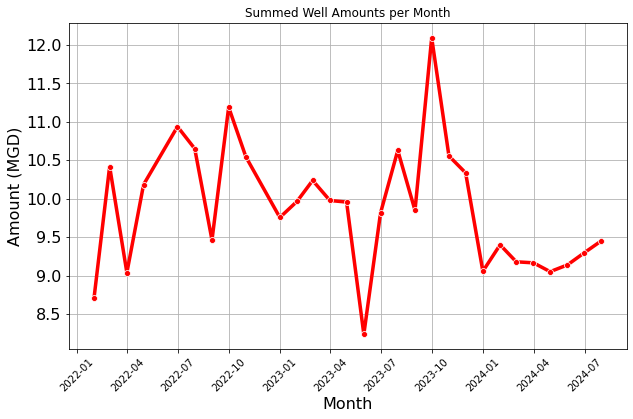

In [26]:
production_well_data = aggregated_well_data.groupby('TimeframeEnd')['Amount'].sum().reset_index()
production_well_data['Amount_MGD'] = production_well_data['Amount'] * (1/30440000)

#Plot Line data
plt.figure(figsize=(10, 6))
sns.lineplot(x='TimeframeEnd', y='Amount_MGD', data=production_well_data, marker='o', color='red', linewidth=3.5)

plt.title('Summed Well Amounts per Month')
plt.xlabel('Month',fontsize=16)
plt.ylabel('Amount (MGD)',fontsize=16)
plt.yticks(fontsize=16)  # Increase y-axis labels font size
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


More ways to visualize well data distribution:
    

In [ ]:
def plot_violin_box(transformed_well_data):
    transformed_well_data['Month'] = transformed_well_data['Month'].astype(str)
    plt.figure(figsize=(12, 8))

    sns.boxplot(
        x='Month', 
        y='Amount', 
        data=transformed_well_data, 
        whis=1.5, 
        width=0.1, 
        showcaps=True, 
        boxprops={'facecolor':'None'}, 
        showfliers=True,
        medianprops={'color': 'red', 'linewidth': 2}  # Set median line color to bright red
    )
   
    plt.title('Boxplot Distribution of Monthly Well Usage')
    plt.xlabel('Month (YYYY-MM)')
    plt.ylabel('Water Usage (Gallons per Minute)')
    plt.xticks(rotation=45)
    plt.show()


plot_violin_box(transformed_well_data)

## Final Site Specific Dataset

Call final data: combines well data and usage data

In [ ]:
final_aggregated_data = pd.concat([aggregated_data, aggregated_well_data], ignore_index=True)
print(final_aggregated_data.head())

Plot final aggregated data of all Beneficial Use Categories (not wells)

In [ ]:

grouped_data = final_aggregated_data.groupby(['TimeframeEnd', 'BeneficialUseCategory'])['Amount'].sum().reset_index()
other_categories_data = grouped_data[grouped_data['BeneficialUseCategory'] != 'Production Well']
other_categories_data['Amount_MGD'] = other_categories_data['Amount'] * 0.00144
#Set up the figure and axes for the subplots
plt.figure(figsize=(14, 10))
#Plot for other categories
sns.lineplot(x='TimeframeEnd', y='Amount_MGD', hue='BeneficialUseCategory', data=other_categories_data, marker='o')
plt.title('Water Usage Over Time by Beneficial Use Category')
plt.xlabel('Month')
plt.ylabel('Total Amount (MGD)')
plt.xticks(rotation=45) 

#Adjust layout to ensure plots are not overlapping
plt.tight_layout()
plt.show()

## Metadata Table Creations

Metadata tables support the final_aggregated_data dataset that serves as supporting more detailed information to the main dataset. The required metadata tables are defined by the Wade 2.0 Schema

### Metadata Table: Organization

Purpose: Provide organization information that is associated with this water use data

In [ ]:
#This is all stagnant information that is entered manually
def organization_metadata():
    organizations_df = pd.DataFrame(columns=[
        'OrganizationName', 'OrganizationContactEmail', 'OrganizationContactName', 
        'OrganizationPhoneNumber', 'OrganizationWebsite', 'StateCV', 'OrganizationPurview'
    ])
    new_row = pd.DataFrame([{
        'OrganizationName': 'American Samoa Power Authority',
        'OrganizationContactEmail': 'wei@aspower.com',
        'OrganizationContactName': 'Wei Hua-Hsien',
        'OrganizationPhoneNumber': '1 (684) 699-1234',
        'OrganizationWebsite': 'https://www.aspower.com/',
        'StateCV': 'AS',
       ' OrganizationPurview' : 'water utility, production, delivery, consumptive use '


    }])
    organizations_df = pd.concat([organizations_df, new_row], ignore_index=True)
    return organizations_df
organizations_df = organization_metadata()
print(organizations_df)

### Metadate Table: Sites

Purpose: provide high-level site description

In [ ]:
#NOTE: the sites data is stored in the same private github repo
def sites_metadata(cs_data, village_url, well_data_frame):
    # Pull from private GitHub repo
    access_token = os.getenv('GITHUB_TOKEN')
    if not access_token:
        raise ValueError("GitHub token not found in environment variables")
    
    headers = {'Authorization': f'token {access_token}'}
    
    # Load Village Data
    response_vill = requests.get(village_url, headers=headers)
    response_vill.raise_for_status()
    village_coordinates = pd.read_csv(StringIO(response_vill.text))
    
    # Transform Village Data
    village_data = pd.DataFrame()
    village_data['Lat'] = village_coordinates['Y']
    village_data['Long'] = village_coordinates['X']
    village_data['SiteNativeID'] = village_coordinates['VILLAGE']
    village_data['SiteTypeCV'] = ' Village (aggregation of individual water meter use within each village boundary) '

    
    sites_df = pd.concat([village_data, well_data_frame], ignore_index=True)
    
    return sites_df

sites_df = sites_metadata(cs_data, village_url, well_data_frame)
print(sites_df.head())

### Metadata Table: Variables

Purpose: Supply more detailed information to the variable CV column from the main dataset

In [ ]:
def variables_metadata():
    variables_df = pd.DataFrame(columns=[
        'VariableCV', 'AmountUnitCV', 'AggregationIntervalUnitCV'
    ])
    new_rows = pd.DataFrame([
        {'VariableCV': 'Consumptive Use', 'AmountUnitCV': 'Gallons', 'AggregationIntervalUnitCV': 'Month'},
        {'VariableCV': 'Withdrawal', 'AmountUnitCV': 'Gallons', 'AggregationIntervalUnitCV': 'Month'}
    ])
    variables_df = pd.concat([variables_df, new_rows], ignore_index=True)
    return variables_df
variables_df = variables_metadata()
print(variables_df)

### Metadata Table: Water Sources

Purpose: Information on where the water usage/production is coming from

In [ ]:
def watersources_metadata():
    watersources_df = pd.DataFrame(columns=['WaterSourceTypeCV'])
    new_row = pd.DataFrame([{'WaterSourceTypeCV': 'Groundwater'}])
    watersources_df = pd.concat([watersources_df, new_row], ignore_index=True)
    return watersources_df
watersources_df = watersources_metadata()
print(watersources_df)

## Uploading Data

In [ ]:
def upload_to_digitalocean_spaces(file_path):
    spaces_key = os.getenv('SPACES_KEY')
    spaces_secret = os.getenv('SPACES_SECRET')
    space_name = os.getenv('SPACE_NAME')
    space_region = os.getenv('SPACE_REGION')

    if not all([spaces_key, spaces_secret, space_name, space_region]):
        raise ValueError("Missing DigitalOcean Spaces credentials or bucket information")
    
    # Configure the boto3 client
    session = boto3.session.Session()
    client = session.client('s3',
                            region_name=space_region,
                            endpoint_url=f'https://{space_region}.digitaloceanspaces.com',
                            aws_access_key_id=spaces_key,
                            aws_secret_access_key=spaces_secret)

    # Upload the file
    with open(file_path, 'rb') as file:
        client.upload_fileobj(file, space_name, os.path.basename(file_path))

In [ ]:
csv_file_paths = []
    
final_aggregated_csv_path = '/tmp/Final_Aggregated_Data.csv'
final_aggregated_data.to_csv(final_aggregated_csv_path, index=False)
csv_file_paths.append(final_aggregated_csv_path)
    
well_data_frame_csv_path = '/tmp/Well_Data.csv'
well_data_frame.to_csv(well_data_frame_csv_path, index=False)
csv_file_paths.append(well_data_frame_csv_path)
    
sites_df = sites_metadata(cs_data, village_url, well_data_frame)
sites_csv_path = '/tmp/Sites.csv'
sites_df.to_csv(sites_csv_path, index=False)
csv_file_paths.append(sites_csv_path)
    
organizations_df = organization_metadata()
organizations_csv_path = '/tmp/Organization.csv'
organizations_df.to_csv(organizations_csv_path, index=False)
csv_file_paths.append(organizations_csv_path)
    
variables_df = variables_metadata()
variables_csv_path = '/tmp/Variables.csv'
variables_df.to_csv(variables_csv_path, index=False)
csv_file_paths.append(variables_csv_path)
    
watersources_df = watersources_metadata()
watersources_csv_path = '/tmp/WaterSources.csv'
watersources_df.to_csv(watersources_csv_path, index=False)
csv_file_paths.append(watersources_csv_path)
    
for file_path in csv_file_paths:
        upload_to_digitalocean_spaces(file_path)
    
retu{"csv_file_paths": csv_file_paths}

### Analysis for writeup: Pull straight from the csvs online : 


In [36]:
# Load up the master dataframe 
URL = "https://aspa-wudr.sfo3.digitaloceanspaces.com/Final_Aggregated_Data.csv"
data_1 = pd.read_csv(URL)
filtered_df = data_1[data_1['SiteNativeID'].str.contains("Well", case=False, na=False)]  # Select Just wells 

# Load up sites
url = "https://aspa-wudr.sfo3.digitaloceanspaces.com/Sites.csv"
Sites_df = pd.read_csv(url)

# average_amount_df is the average in  GPM for each well  
average_amount_df = filtered_df.groupby('SiteNativeID')['Amount'].mean().reset_index()  # Average across each site 
average_amount_df['Amount'] =    average_amount_df['Amount'] / (30.44 * 24 * 60)  # Gal/month to GPM
average_amount_df.rename(columns={'Amount': 'Amount_(GPM)'}, inplace=True) # Change column name 

# Merge coordinates onto the data and print new csv
average_amount_df_LL = pd.merge(average_amount_df, Sites_df[['Lat', 'Long', 'SiteNativeID']], on='SiteNativeID', how='left')
average_amount_df_LL.to_csv(os.path.join("..", "Outputs", "Ave_Well_Extraction_GPM.csv"))

In [ ]:
test = Sites_df[Sites_df['SiteNativeID'].str.contains("Well", case=False, na=False)]
test.reset_index()